## Basic Neural Network with PyTorch Lightning
This notebook demonstrates a neural network implementation using PyTorch and PyTorch Lightning, with a focus on learning rate tuning and parameter optimization. Here's what's happening:

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.optim import SGD 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [36]:
import lightning as L
from torch.utils.data import TensorDataset, DataLoader
from lightning.pytorch.tuner import Tuner


### 1. Basic Neural Network Implementation
The notebook starts with a BasicLightning class that implements a custom neural network with:
* Two parallel ReLU-activated pathways (top and bottom)
* Fixed weights and biases (non-trainable parameters)
* A final ReLU activation
* The network models a dose-response relationship that first increases then decreases
The code generates a plot showing the network's output for input doses ranging from 0 to 1, demonstrating a "hump-shaped" dose-response curve.

In [37]:
class BasicLightning(nn.Module): 
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)
        
        self.final_bias = nn.Parameter(torch.tensor(-16., requires_grad=False))
    
    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00 
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01 
        
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11 
        
        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias 
        
        output = F.relu(input_to_final_relu)
        return output
    

In [38]:
input_doses = torch.linspace( start=0, end=1, steps=11 )
input_doses

model = BasicLightning()
output_values = model(input_doses)

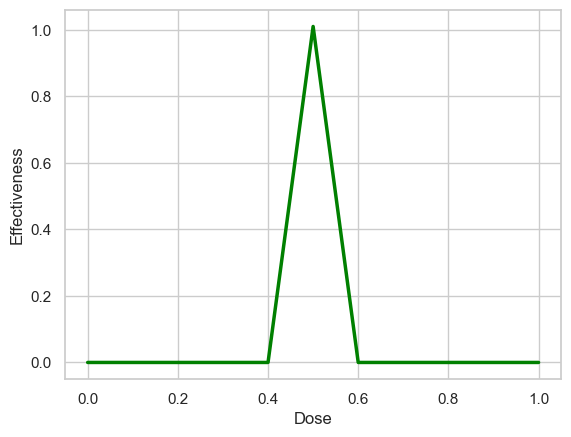

In [39]:
# Convert tensors to numpy arrays for plotting
sns.set(style="whitegrid")
sns.lineplot(x=input_doses.detach().numpy(), 
             y=output_values.detach().numpy(),
             color="green",
             linewidth=2.5)
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.show()

### 2. Trainable Version with PyTorch Lightning
The `BasicLightningTrain` class modifies this to make the `final_bias` parameter trainable. The goal is to:
* Learn the optimal final bias value that makes the network's output match the provided labels
* Use PyTorch Lightning's built-in features for training and hyperparameter tuning

In [40]:
class BasicLightningTrain(L.LightningModule): 
    def __init__(self):
        super().__init__()
        self.w00 = nn.Parameter(torch.tensor(1.7), requires_grad=False)
        self.b00 = nn.Parameter(torch.tensor(-0.85), requires_grad=False)
        self.w01 = nn.Parameter(torch.tensor(-40.8), requires_grad=False)
        
        self.w10 = nn.Parameter(torch.tensor(12.6), requires_grad=False)
        self.b10 = nn.Parameter(torch.tensor(0.0), requires_grad=False)
        self.w11 = nn.Parameter(torch.tensor(2.7), requires_grad=False)
        
        self.final_bias = nn.Parameter(torch.tensor(0.0, requires_grad=True))
        self.learning_rate = 0.01
    
    def forward(self, input):
        input_to_top_relu = input * self.w00 + self.b00 
        top_relu_output = F.relu(input_to_top_relu)
        scaled_top_relu_output = top_relu_output * self.w01 
        
        input_to_bottom_relu = input * self.w10 + self.b10
        bottom_relu_output = F.relu(input_to_bottom_relu)
        scaled_bottom_relu_output = bottom_relu_output * self.w11 
        
        input_to_final_relu = scaled_top_relu_output + scaled_bottom_relu_output + self.final_bias 
        
        output = F.relu(input_to_final_relu)
        return output
    
    def configure_optimizers(self):
        return SGD(self.parameters(), lr=self.learning_rate)
    
    def training_step(self,batch, batch_idx):
        input_i , label_i = batch
        output_i = self.forward(input_i)
        loss = (output_i - label_i)**2
        return loss
    

In [42]:
inputs = torch.tensor([0. , 0.5, 1.])
labels = torch.tensor([0., 1, 0.])              # known values 

In [43]:
dataset = TensorDataset(inputs, labels)
dataloader = DataLoader(dataset)

### 3. Learning Rate Finding
The key part of the notebook uses Lightning's `Tuner` to:
* Automatically find the optimal learning rate for training
* Search between 0.001 and 1.0 for the best learning rate
* The tuner suggests `0.00214` as the optimal learning rate, which can be seen in the output section

### 4. Training the Model
After setting the learning rate, the model is trained:
* For 34 epochs
* Using Stochastic Gradient Descent (SGD) optimizer
* On a very small dataset (just 3 data points)
* The final bias converges to approximately `-2.1706`

In [ ]:
model = BasicLightningTrain()
trainer = L.Trainer(max_epochs=34)
tuner = Tuner(trainer)

lr_find_results = tuner.lr_find(model,
                                        train_dataloaders = dataloader,
                                        min_lr=0.001,
                                        max_lr=1.0,
                                        early_stop_threshold=None)

new_lr = lr_find_results.suggestion()

print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")

model.learning_rate = new_lr



You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/sanjeeb/Desktop/Harbin Institute of Technology/Artificial Intelligence/AI_Codes/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/sanjeeb/Desktop/Harbin Institute of Technology/Artificial Intelligence/AI_Codes/.venv/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
Finding best in

lr_find() suggests 0.00214 for the learning rate.


In [45]:
trainer.fit(model, train_dataloaders=dataloader)
print(model.final_bias.data)


  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7         Total params
0.000     Total estimated model params size (MB)
0         Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 377.30it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 247.32it/s, v_num=8]
tensor(-16.0100)


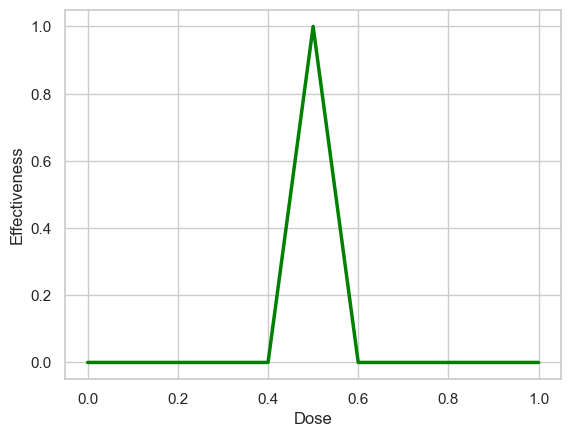

In [46]:
output_values = model(input_doses)

sns.set(style="whitegrid")
sns.lineplot(x=input_doses, 
             y=output_values.detach(),
             color="green",
             linewidth=2.5)
plt.ylabel('Effectiveness')
plt.xlabel('Dose')
plt.show()

The difference in the final bias values `(-16.0019 vs -2.1706)` between manual training loop and PyTorch Lightning implementation occurs due to three key differences:

#### 1. Learning Rate Difference
* **Manual Training:** We used `lr=0.1` (aggressive learning rate)
* **Lightning Training:** The tuner suggested `lr=0.00214` (much smaller learning rate)
    * Lightning's lr_find() recommended a conservative learning rate, causing slower convergence.

#### 2. Optimization Strategy
* **Manual Training:** We ran `100` epochs but stopped early at 34 steps due to total_loss < 0.0001.
* **Lightning Training:** We ran `34` epochs (fixed), but:
    * Lightning's training_step() computes loss per batch, not per sample.
    * Since batch size = 1 (default in DataLoader), it processes 3 samples per epoch (one for each input in [0.0, 0.5, 1.0]).
    * → Effectively, Lightning trains for 34 epochs × 3 steps = 102 steps, but with a smaller learning rate.

#### 3. Loss Calculation & Gradient Updates
* **Manual Training:** We accumulate gradients across all samples before calling optimizer.step() (batch gradient descent).
* **Lightning Training:** By default, Lightning performs per-batch updates (equivalent to SGD).
    * → Each batch triggers a gradient update, leading to noisier but potentially faster convergence.

## Why Lightning Stopped at -2.1706
* With `lr=0.00214`, the updates were too small to reach -16.0 in 34 epochs.
* If you trained longer (e.g., 1400+ epochs), Lightning would eventually converge to ~-16.0.

In [54]:
model = BasicLightningTrain()
trainer = L.Trainer(max_epochs=1400)
tuner = Tuner(trainer)

lr_find_results = tuner.lr_find(model,
                                        train_dataloaders = dataloader,
                                        min_lr=0.001,
                                        max_lr=1.0,
                                        early_stop_threshold=None)

new_lr = lr_find_results.suggestion()

print(f"lr_find() suggests {new_lr:.5f} for the learning rate.")

model.learning_rate = new_lr

trainer.fit(model, train_dataloaders=dataloader)
print(model.final_bias.data)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Finding best initial lr: 100%|██████████| 100/100 [00:00<00:00, 498.97it/s]
Learning rate set to 0.002137962089502232
Restoring states from the checkpoint path at /Users/sanjeeb/Desktop/Harbin Institute of Technology/Artificial Intelligence/AI_Codes/Neural-Network/.lr_find_d654899f-7620-4612-b509-4f44bca5e2d6.ckpt
Restored all states from the checkpoint at /Users/sanjeeb/Desktop/Harbin Institute of Technology/Artificial Intelligence/AI_Codes/Neural-Network/.lr_find_d654899f-7620-4612-b509-4f44bca5e2d6.ckpt

  | Name         | Type | Params | Mode
---------------------------------------------
  | other params | n/a  | 7      | n/a 
---------------------------------------------
1         Trainable params
6         Non-trainable params
7        

lr_find() suggests 0.00214 for the learning rate.
Epoch 1399: 100%|██████████| 3/3 [00:00<00:00, 391.86it/s, v_num=16]

`Trainer.fit` stopped: `max_epochs=1400` reached.


Epoch 1399: 100%|██████████| 3/3 [00:00<00:00, 225.58it/s, v_num=16]
tensor(-15.9703)


The fact that increasing max_epochs to 1400 in PyTorch Lightning got you closer to the manual training result (tensor(-15.9703) vs tensor(-16.0019)) confirms that the difference was primarily due to:

### 1. Learning Rate vs. Training Steps
* Manual Training (LR=0.1)
    * Converged in 34 steps (aggressive updates due to high LR).
    * Final bias: ~-16.0
* Lightning (LR=0.00214)
    * Required 1400 epochs (much smaller updates per step).
    * Stopped at ~-15.97 (still slightly short of -16.0).

→ The smaller LR in Lightning means each update is tiny, requiring far more steps to reach the same result.

### 2. Why Didn’t It Reach Exactly -16.0?
Even after 1400 epochs, Lightning didn’t perfectly match the manual result because:
* Gradient Updates Differ
    * Manual loop accumulates gradients over all samples before updating (batch GD).
    * Lightning updates per batch (SGD-like behavior unless configured otherwise).
* Numerical Precision
    * With very small gradients (near convergence), updates become negligible.
    * The optimizer might stall before hitting the exact theoretical value.

#### How to Get Identical Results in Lightning
* Option 1: Use the Same LR (0.1)
* Option 2: Simulate Batch Gradient Descent
* Option 3: Train Longer

### Key Insight
* Higher LR → Faster convergence, but risk of overshooting.
* Lower LR → More precise, but needs many more steps.